# Yeast Data Set 
## Description

Data set of yeast samples containing their attributes as well as the localization of their proteins within the sample.

The column attributes are as follows:

| Id | Attribute |Domain |
| -   | ----------- |----------- |
| 1   | Sequence Name | Number and letter sequence. |
| 2   |  McGeoch's method for signal sequence recognition.   | 0 - 1 |
| 3   | Von Heijne's method for signal sequence recognition. |0 - 1 |
| 4   | Score of the ALOM membrane spanning region prediction program. | 0 - 1 |
| 5   | Score of discriminant analysis of the amino acid content of the N-terminal region. | 0 - 1 |
| 6   | Presence of "HDEL" substring (thought to act as a signal forretention in the endoplasmic reticulum lumen).Binary attribute. | 0 or 0.5 |
| 7   | Peroxisomal targeting signal in the C-terminus.   |0 - 1 |
| 8   |  Score of discriminant analysis of the amino acid content of vacuolar and extracellular proteins.| 0 - 1 |
| 9   | Score of discriminant analysis of nuclear localization signals of nuclear and non-nuclear proteins.| 0 - 1 |
| 10  | The class of the yeast sample. | Location ID |

## Importing the Dataset

In [2]:
import numpy as np
import pandas as pd

In [3]:
headers = ['Sequence_name','MCG','GVH','ALM','MIT', 'ERL','POX','VAC','NUC', 'Class']
data = pd.read_csv("../../datasets/classification/yeast-data", header = None, names = headers, delimiter=r"\s+")

## Preparing the Dataset

In [4]:
from sklearn.model_selection import train_test_split

X = (data.iloc[:,1:data.shape[1]-1]).to_numpy().flatten().reshape(data.shape[0],-1)
y = data.iloc[:,data.shape[1]-1:data.shape[1]]

y.Class = pd.Categorical(y.Class)
y.Class = y.Class.cat.codes
y = y.to_numpy().flatten()

X_train, X_test, y_train, y_test= train_test_split(X, y, train_size=0.80, test_size = 0.20, random_state=0)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, train_size=0.75, test_size = 0.25, random_state=0)

The following block prints the shape and column datatypes of the processed dataset.

In [5]:
print(data.shape)
print(data.dtypes)

(1484, 10)
Sequence_name     object
MCG              float64
GVH              float64
ALM              float64
MIT              float64
ERL              float64
POX              float64
VAC              float64
NUC              float64
Class             object
dtype: object


## Train on Multiple Classifiers

In [6]:
# Manage imports
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.neighbors
from sklearn.naive_bayes import GaussianNB
import sklearn.neural_network
from utilities import train_estimators, plot_estimator_scores

### Logistic Regression Classification

Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.001, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.01, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.1, max_iter=10000, random_state=0)...
Training LogisticRegression(C=1.0, max_iter=10000, random_state=0)...


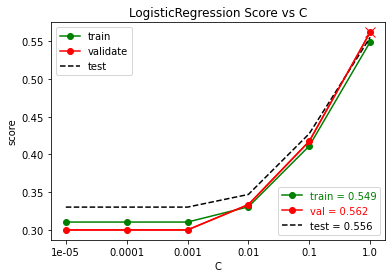

In [16]:
adjusted_parameter = 'C'
adjusted_parameter_values = [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]

LogisticRegressionEstimators = train_estimators(X_train, y_train,
                                                sklearn.linear_model.LogisticRegression,
                                                adjusted_parameter,
                                                adjusted_parameter_values,
                                                max_iter=10000,
                                                random_state=0)
plot_estimator_scores(LogisticRegressionEstimators,
                      adjusted_parameter,adjusted_parameter_values,
                      X_train, y_train, X_test, y_test, X_val, y_val)

### SVM Classification

Training SVC(C=0.01, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=0.1, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=1.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=10.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=100.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=1000.0, gamma=0.0001, max_iter=10000, random_state=0)...


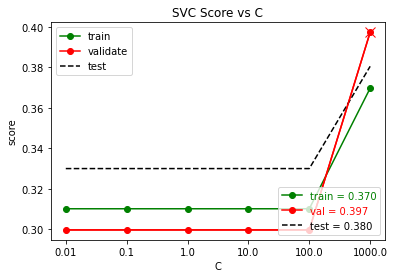

In [17]:
adjusted_parameter = 'C'
adjusted_parameter_values = [0.01, 0.1,1.0,10.0,100.0,1000.0]

SVMEstimators = train_estimators(X_train, y_train,
                                    sklearn.svm.SVC,
                                    adjusted_parameter, adjusted_parameter_values,
                                    gamma=0.0001,
                                    max_iter=10000,
                                    random_state=0)

plot_estimator_scores(SVMEstimators,
                      adjusted_parameter, adjusted_parameter_values,
                      X_train, y_train, X_test, y_test, X_val, y_val)

### Decision Tree Classification

Training DecisionTreeClassifier(max_depth=1, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=5, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=10, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=20, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=50, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=100, splitter='random', random_state=0)...


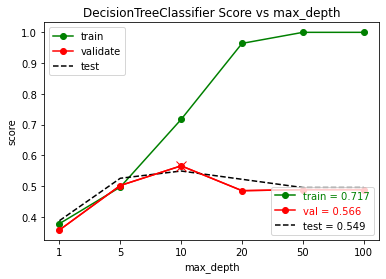

In [19]:
adjusted_parameter = 'max_depth'
adjusted_parameter_values = [1, 5, 10, 20, 50, 100]

DecisionTreeEstimators = train_estimators(X_train, y_train,
                                            sklearn.tree.DecisionTreeClassifier,
                                            adjusted_parameter, adjusted_parameter_values,
                                            splitter='random',
                                            random_state=0)
plot_estimator_scores(DecisionTreeEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        X_train, y_train, X_test, y_test, X_val, y_val)

### RandomForest Classification

Training RandomForestClassifier(max_depth=1, random_state=0)...
Training RandomForestClassifier(max_depth=5, random_state=0)...
Training RandomForestClassifier(max_depth=10, random_state=0)...
Training RandomForestClassifier(max_depth=20, random_state=0)...
Training RandomForestClassifier(max_depth=50, random_state=0)...
Training RandomForestClassifier(max_depth=100, random_state=0)...


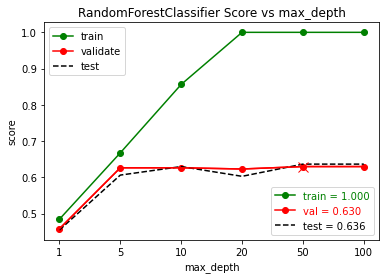

In [20]:
adjusted_parameter = 'max_depth'
adjusted_parameter_values = [1, 5, 10, 20, 50, 100]

RandomTreeEstimators = train_estimators(X_train, y_train,
                                        sklearn.ensemble.RandomForestClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        random_state=0)
plot_estimator_scores(RandomTreeEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        X_train, y_train, X_test, y_test, X_val, y_val)

### K-nearest Classification

Training KNeighborsClassifier(weights=uniform, n_neighbors=2)...
Training KNeighborsClassifier(weights=distance, n_neighbors=2)...


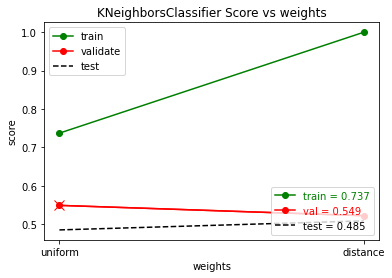

In [21]:
adjusted_parameter = 'weights'
adjusted_parameter_values = ['uniform','distance']

KNearestEstimators = train_estimators(X_train, y_train,
                                        sklearn.neighbors.KNeighborsClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        n_neighbors=2)
plot_estimator_scores(KNearestEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        X_train, y_train, X_test, y_test, X_val, y_val)

Training KNeighborsClassifier(algorithm=auto, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=ball_tree, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=kd_tree, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=brute, n_neighbors=2)...


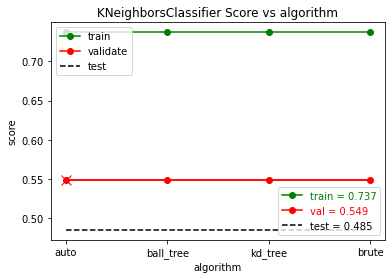

In [22]:
adjusted_parameter = 'algorithm'
adjusted_parameter_values = ['auto', 'ball_tree', 'kd_tree','brute']

KNearestEstimators = train_estimators(X_train, y_train,
                                        sklearn.neighbors.KNeighborsClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        n_neighbors=2)
plot_estimator_scores(KNearestEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        X_train, y_train, X_test, y_test, X_val, y_val)

## Ada Boost Classification

Training AdaBoostClassifier(n_estimators=10, random_state=0)...
Training AdaBoostClassifier(n_estimators=50, random_state=0)...
Training AdaBoostClassifier(n_estimators=100, random_state=0)...
Training AdaBoostClassifier(n_estimators=500, random_state=0)...
Training AdaBoostClassifier(n_estimators=1000, random_state=0)...
Training AdaBoostClassifier(n_estimators=5000, random_state=0)...


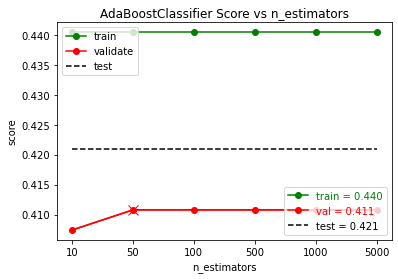

In [23]:
adjusted_parameter = 'n_estimators'
adjusted_parameter_values = [10, 50, 100, 500, 1000, 5000]

AdaBoostEstimators = train_estimators(X_train, y_train,
                                        sklearn.ensemble.AdaBoostClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        random_state=0)
plot_estimator_scores(AdaBoostEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        X_train, y_train, X_test, y_test, X_val, y_val)

## Gaussian Naive Bayes Classification

In [7]:
gaussian_nb = sklearn.naive_bayes.GaussianNB()
NaiveBayesEstimator = gaussian_nb.fit(X_train, y_train)
gaussian_nb_train_score = NaiveBayesEstimator.score(X_train, y_train)
gaussian_nb_test_score =  NaiveBayesEstimator.score(X_test, y_test)
gaussian_nb_val_score =  NaiveBayesEstimator.score(X_val, y_val)
print(f'{gaussian_nb_train_score=}, {gaussian_nb_val_score=}, {gaussian_nb_test_score=}')

gaussian_nb_train_score=0.20337078651685395, gaussian_nb_val_score=0.20875420875420875, gaussian_nb_test_score=0.14814814814814814


### Neural Network Classification Through a Multi-Layer Perceptron

In [8]:
mlp = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(), activation='relu',
                                            batch_size=100, max_iter=1000, learning_rate_init=0.01,
                                            momentum=0.4, random_state=0, verbose=True).fit(X_train, y_train)

print(f'Training Score: {mlp.score(X_train, y_train)}')
print(f'Testing Score: {mlp.score(X_test, y_test)}')
print(f'Validation Score: {mlp.score(X_val, y_val)}')

mlp = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(16), activation='relu',
                                            batch_size=100, max_iter=1000, learning_rate_init=0.01,
                                            momentum=0.4, random_state=0, verbose=True).fit(X_train, y_train)

print(f'Training Score: {mlp.score(X_train, y_train)}')
print(f'Testing Score: {mlp.score(X_test, y_test)}')
print(f'Validation Score: {mlp.score(X_val, y_val)}')


Iteration 1, loss = 2.37315580
Iteration 2, loss = 2.08798495
Iteration 3, loss = 1.91550082
Iteration 4, loss = 1.82604356
Iteration 5, loss = 1.78368398
Iteration 6, loss = 1.76024388
Iteration 7, loss = 1.74583736
Iteration 8, loss = 1.73330482
Iteration 9, loss = 1.72359178
Iteration 10, loss = 1.71386973
Iteration 11, loss = 1.70548180
Iteration 12, loss = 1.69665956
Iteration 13, loss = 1.68881066
Iteration 14, loss = 1.68002348
Iteration 15, loss = 1.67228212
Iteration 16, loss = 1.66380587
Iteration 17, loss = 1.65595501
Iteration 18, loss = 1.64852489
Iteration 19, loss = 1.64111932
Iteration 20, loss = 1.63357198
Iteration 21, loss = 1.62579590
Iteration 22, loss = 1.61876100
Iteration 23, loss = 1.61147122
Iteration 24, loss = 1.60458558
Iteration 25, loss = 1.59841665
Iteration 26, loss = 1.59065579
Iteration 27, loss = 1.58380866
Iteration 28, loss = 1.57716940
Iteration 29, loss = 1.57061504
Iteration 30, loss = 1.56420947
Iteration 31, loss = 1.55820197
Iteration 32, los

Iteration 257, loss = 1.14324548
Iteration 258, loss = 1.14245190
Iteration 259, loss = 1.14174729
Iteration 260, loss = 1.14111441
Iteration 261, loss = 1.14120430
Iteration 262, loss = 1.13973199
Iteration 263, loss = 1.13954110
Iteration 264, loss = 1.13966902
Iteration 265, loss = 1.13902950
Iteration 266, loss = 1.13836095
Iteration 267, loss = 1.13758531
Iteration 268, loss = 1.13755673
Iteration 269, loss = 1.13673260
Iteration 270, loss = 1.13597596
Iteration 271, loss = 1.13567253
Iteration 272, loss = 1.13603715
Iteration 273, loss = 1.13437722
Iteration 274, loss = 1.13477208
Iteration 275, loss = 1.13436417
Iteration 276, loss = 1.13426760
Iteration 277, loss = 1.13282167
Iteration 278, loss = 1.13260503
Iteration 279, loss = 1.13196289
Iteration 280, loss = 1.13156956
Iteration 281, loss = 1.13110222
Iteration 282, loss = 1.13062092
Iteration 283, loss = 1.12975660
Iteration 284, loss = 1.12998075
Iteration 285, loss = 1.12975809
Iteration 286, loss = 1.12942027
Iteration 

Iteration 526, loss = 1.06981690
Iteration 527, loss = 1.07014625
Iteration 528, loss = 1.06936794
Iteration 529, loss = 1.06960241
Iteration 530, loss = 1.06940182
Iteration 531, loss = 1.06958874
Iteration 532, loss = 1.06898364
Iteration 533, loss = 1.06891933
Iteration 534, loss = 1.06854875
Iteration 535, loss = 1.06837251
Iteration 536, loss = 1.06878007
Iteration 537, loss = 1.06817839
Iteration 538, loss = 1.06808061
Iteration 539, loss = 1.06867643
Iteration 540, loss = 1.06768751
Iteration 541, loss = 1.06842483
Iteration 542, loss = 1.06840780
Iteration 543, loss = 1.06772553
Iteration 544, loss = 1.06755733
Iteration 545, loss = 1.06723813
Iteration 546, loss = 1.06731967
Iteration 547, loss = 1.06741889
Iteration 548, loss = 1.06728581
Iteration 549, loss = 1.06694471
Iteration 550, loss = 1.06743109
Iteration 551, loss = 1.06669613
Iteration 552, loss = 1.06684648
Iteration 553, loss = 1.06601664
Iteration 554, loss = 1.06619216
Iteration 555, loss = 1.06645204
Iteration 

Iteration 807, loss = 1.04732290
Iteration 808, loss = 1.04721157
Iteration 809, loss = 1.04769623
Iteration 810, loss = 1.04745626
Iteration 811, loss = 1.04791839
Iteration 812, loss = 1.04740689
Iteration 813, loss = 1.04719971
Iteration 814, loss = 1.04768280
Iteration 815, loss = 1.04766531
Iteration 816, loss = 1.04770666
Iteration 817, loss = 1.04737681
Iteration 818, loss = 1.04710676
Iteration 819, loss = 1.04819674
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training Score: 0.6
Testing Score: 0.5824915824915825
Validation Score: 0.6195286195286195
Iteration 1, loss = 2.13658554
Iteration 2, loss = 1.82210957
Iteration 3, loss = 1.74272059
Iteration 4, loss = 1.70755136
Iteration 5, loss = 1.68278440
Iteration 6, loss = 1.65992390
Iteration 7, loss = 1.63782571
Iteration 8, loss = 1.60823539
Iteration 9, loss = 1.58575275
Iteration 10, loss = 1.55694295
Iteration 11, loss = 1.53015762
Iteration 12, loss = 1.50080249
Iteration 13, l

Iteration 236, loss = 1.00662830
Iteration 237, loss = 1.00513968
Iteration 238, loss = 1.00688501
Iteration 239, loss = 1.00880834
Iteration 240, loss = 1.00901063
Iteration 241, loss = 1.00458826
Iteration 242, loss = 1.00598635
Iteration 243, loss = 1.00508327
Iteration 244, loss = 1.00625739
Iteration 245, loss = 1.01350511
Iteration 246, loss = 1.01268253
Iteration 247, loss = 1.00917259
Iteration 248, loss = 1.00487290
Iteration 249, loss = 1.00610392
Iteration 250, loss = 1.01200458
Iteration 251, loss = 1.01237364
Iteration 252, loss = 1.00786120
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training Score: 0.6179775280898876
Testing Score: 0.5791245791245792
Validation Score: 0.6195286195286195
